#Lab07 - Linear Regression Lab Enhancement

The original lab explores the implementation of linear regression (simple, multi-variable and polynomial) models. It focuses on the derivation of formula without discussing much on its real life application.


In this lab enhancement, the concept of Linear Regression is applied to a real-world dataset to showcase their practical applications. Also, we will explore a new type of linear regression models known as Lasso to derive a better equation in predicting.

This lab also shows the calculation behind the Mean Squared Error and R-squared, so students know where the numbers come from.

## Introduction to the Dataset

The dataset lists the residential properties in Ampang, Malaysia.
It details each properties size, type (apartment, flat, terraced house, etc), number of floors, scheme, year of valuation and price. The primary goal is to predict the sales price using those available features.

In [ ]:
# Get our data from Google Drive (needs log in credential)
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# read the csv file
import pandas as pd
df=pd.read_csv("/content/drive/MyDrive/Ampang District.csv")

In [ ]:
df.shape # this line reveals we have 634 properties with 6 columns

(633, 6)

In [ ]:
df.head()

,LOT_SIZE,CATEGORY,NO_OF_FLOOR,SCHEME,PRICE,DATE_OF_VALUATION
0,1226.00,Detached House,1,KG PANDAN,560000,2017
1,1204.15,Detached House,2,KAW JLN AMPANG/AMPANG HILIR,4800000,2020
2,1116.00,Detached House,2,DATO KERAMAT HUJUNG,2400000,2017
3,833.00,Detached House,1,KG PANDAN,850000,2018
4,816.00,Detached House,2,DATO KERAMAT HUJUNG,2200000,2020


For a more accurate price prediction of property, we will compare the properties in its own category. The code below shows the property category and counts in the dataset.

In [ ]:
property_count = df['CATEGORY'].value_counts()

print(property_count)

CATEGORY
Flat                     239
Condominium/Apartment    217
Terraced House            70
Low-Cost Flat             62
Town Houses               27
Detached House            18
Name: count, dtype: int64


In this context, the <b>independent variables</b> are the features to be analysed. Our independent variables, in this case, are the lot size (in square feet), its category type, the number of floors, the scheme/developer and the year of valuation.
<b>The dependent variable</b>, which is our target output, is the sales price.

In [ ]:
# We will begin with the standard import

%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

## Feature Engineering

Feature engineering is choosing the most relevant features for our model. It is important that we provide the most relevant and informative input data to feed our machine learning model. Since we have a lot of categories or properties, we will mainly focus on "Condominium/Apartment" in Ampang. You can try out other category on your own!

                PRICE  NO_OF_FLOOR  LOT_SIZE
PRICE        1.000000     0.278214  0.873457
NO_OF_FLOOR  0.278214     1.000000  0.259929
LOT_SIZE     0.873457     0.259929  1.000000


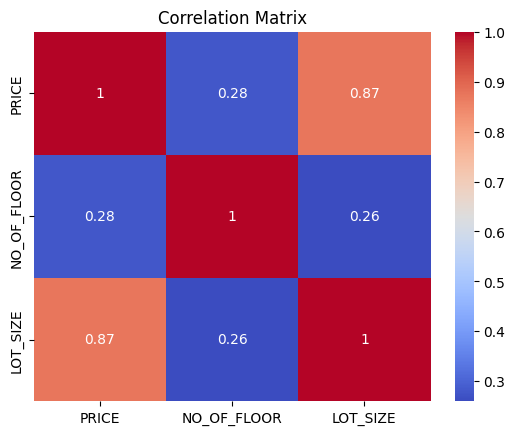

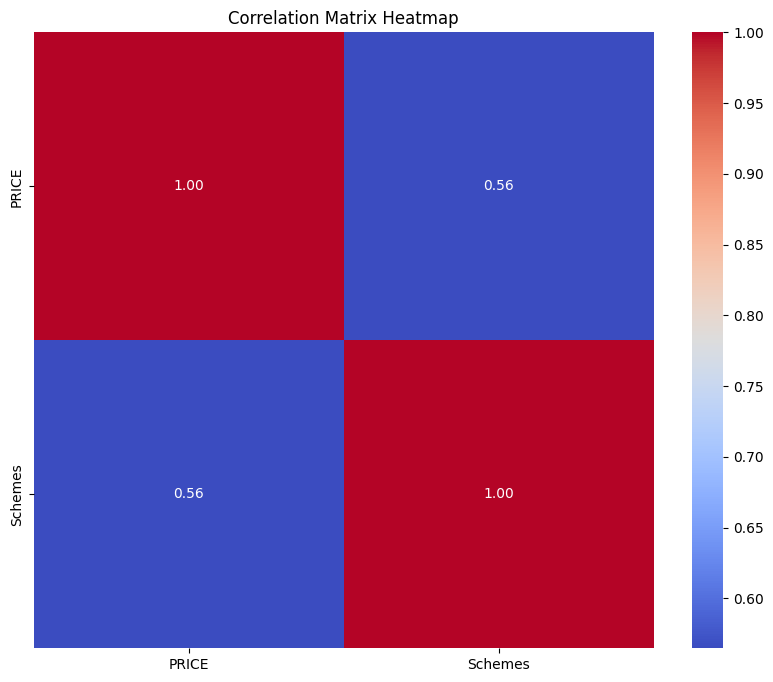

In [ ]:
df = df[df['CATEGORY'] == 'Condominium/Apartment']

selected_columns = ['PRICE', 'NO_OF_FLOOR', 'LOT_SIZE']

df_encoded = pd.get_dummies(df, columns=['CATEGORY', 'SCHEME'])

# Calculating the correlation matrix
correlation_matrix = df[selected_columns].corr()

# Displaying the correlation matrix
print(correlation_matrix)

# Create a heatmap to visualize the correlation matrix
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm')
plt.title('Correlation Matrix')
plt.show()

# For categorical columns (Scheme)
df['SCHEMES'] = df['SCHEME'].astype('category')

# Encode categorical columns as integers
df['Schemes'] = df['SCHEMES'].cat.codes

# Calculate the correlation matrix
corr_matrix = df[['PRICE', 'Schemes']].corr()

# Create a heatmap of the correlation matrix
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Matrix Heatmap')
plt.show()

It turns out from our heatmap, the variables lot size and scheme are the most relevant features to determine our Property Price. Hence, we will include these 2 features to our machine learning model.

We will also remove any outliers for a more precise prediction.

In [ ]:
# Already run! (DON'T RUN AGAIN) will remove more data

from scipy import stats

z_scores = np.abs(stats.zscore(df['PRICE']))

# Any data points with a Z-Score greater than 3 will be considered as outliers
threshold = 3
outlier_indices = np.where(z_scores > threshold)[0] # Getting the index of outliers

# Get the actual outlier values
outliers = df.iloc[outlier_indices]

print("Outlier values:")
print(outliers)

cleaned_df = df.drop(df.index[outlier_indices])
print(f"Number of outliers removed: {len(outlier_indices)}")


Outlier values:
    LOT_SIZE               CATEGORY  NO_OF_FLOOR                    SCHEME  \
50     193.0  Condominium/Apartment           25  MUTIARA UPPER EAST CONDO   

      PRICE  DATE_OF_VALUATION                   SCHEMES  Schemes  
50  1550000               2018  MUTIARA UPPER EAST CONDO        8  
Number of outliers removed: 1


In [ ]:
cleaned_df.shape # We have 216 data available

(216, 8)

#Univariate Linear Regression#

The most simple approach of a linear regression is a straight-line fit to data.
A straight-line fit is a model of the form:

$$
y = ax + b
$$

y is our independent variable, x is the dependent variable (the parameter we watches for change), b is the intercept and a is the slope (rate of change of the dependent variable).

In this case: the y represents the house price; the x represents the feature of the house (for example lot_size).

To illustrate, we can create a scatter plot of Size vs Price and perform linear regression to predict the sale price based on size. This is known as _univariate linear regression_ as it has a single feature. We will look into the property type Condominium/Apartment.


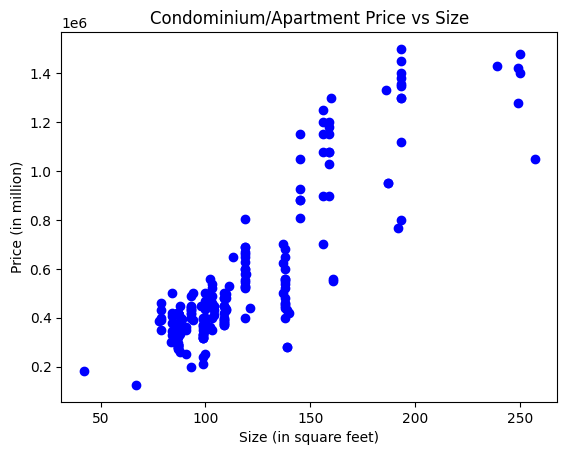

In [ ]:
X = cleaned_df['LOT_SIZE'].values.reshape(-1, 1)
Y = cleaned_df['PRICE'].values

plt.scatter(X, Y, color="blue", label="Data Points")
plt.xlabel('Size (in square feet)')
plt.ylabel('Price (in million)')
plt.title('Condominium/Apartment Price vs Size')
plt.show()


In [ ]:
from sklearn.linear_model import LinearRegression # We can use Scikit-Learn's LinearRegression estimator to fit this data and construct the best-fit line
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score

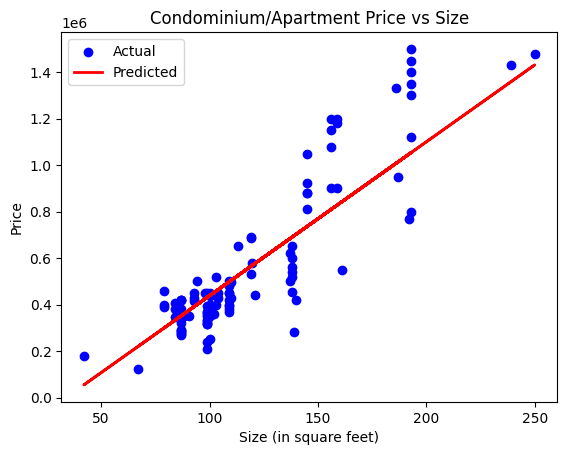

In [ ]:
# 1. Extract features (size) and target (price)

X = cleaned_df['LOT_SIZE'].values.reshape(-1, 1)
Y = cleaned_df["PRICE"].values

# 2. Split the data into training and testing set
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.5, random_state=12) # the random_state is a seed to ensure random training dataset is consistent, 12 is arbitrary number

# 3. Create the linear regression model and train the model
model = LinearRegression()
model.fit(X_train, Y_train)

# 4. Do predictions on the test set
Y_pred = model.predict(X_test)

# 5. Plot it!
plt.scatter(X_test, Y_test, color='blue', label='Actual')
plt.plot(X_test, Y_pred, color='red', linewidth=2, label='Predicted')
plt.xlabel('Size (in square feet)')
plt.ylabel('Price')
plt.title('Condominium/Apartment Price vs Size')
plt.legend()
plt.show()




In [ ]:
# Evaluate the model (will be further discussed in next section)
mse = mean_squared_error(Y_test, Y_pred)
r2 = r2_score(Y_test, Y_pred)

print(f'Mean Squared Error: {mse:.2f}')
print(f'R-squared: {r2}')

Mean Squared Error: 25055918541.77
R-squared: 0.772955464118462


Just note that:
1. Mean Squared Error shows the error magnitude
2. the closer to 1 the R-Squared is, the better!

In [ ]:
# Get the slope (known as the model coefficient) and intercept of the regression line
slope = model.coef_[0] # this slope contains the coefficient for the feature 'size'
intercept = model.intercept_ # the y intercept

print(f'Equation of the linear regression line: Y = {slope:.2f}X + {intercept:.2f}')

Equation of the linear regression line: Y = 6619.74X + -223616.58


The equation above is a linear representation of how size influences price.
It seems like the price increases by 6619.74 RM for each unit increase in size.

 We can infer a positive linear relationship between the size and price of Condominium/Apartment where as the size increases, the price increases.

  The y-intercept -223616.58 represents the predicted value of Y (property price) when X (lot size) is zero. While a negative price does not make practical sense, it indicates where the line would intersect the Y-axis in the mathematical model. It may also suggest that the linear model may not be a perfect fit for smaller lot sizes. We will soon discuss how to address this issue.

# Evaluating the Performance of Regression Models

In these section, we will explore the metrics used to evaluate the performance and accuracy for our House Price linear regression model.




## Mean Squared Error

Mean Squared Error (SEE) tells you how close your regression line is between the predicted values and the actual values. The distance being the "error".

In our case, it tells how far off our model's predictions are from the actual property prices. The lower the MSE, the better the model performance, giving the line of best fit.



The steps behind finding the Mean Squared Error is simply:
1.  Find the difference between the newly predicted value Y and original Y aka the errors.
2. Square the errors.
3. Find the mean

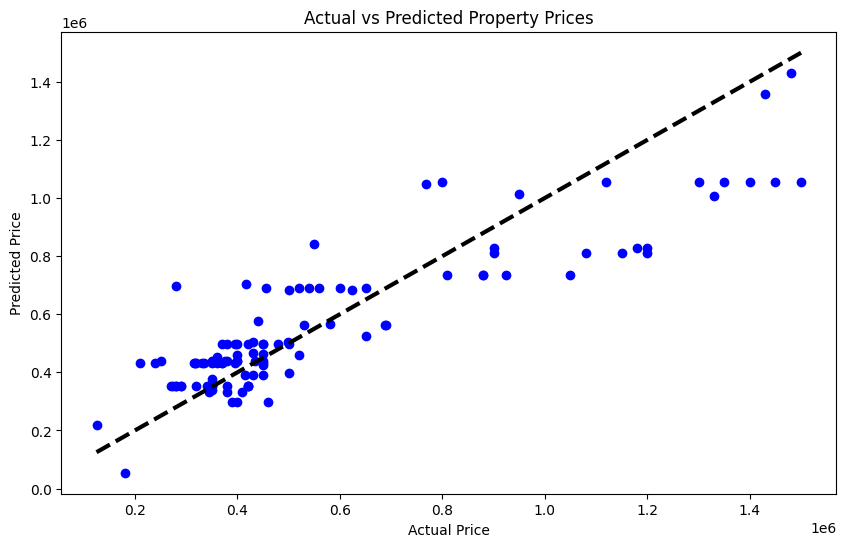

In [ ]:
plt.figure(figsize=(10, 6))
plt.scatter(Y_test, Y_pred, color='blue')
plt.plot([Y_test.min(), Y_test.max()], [Y_test.min(), Y_test.max()], 'k--', lw=3)
plt.xlabel('Actual Price')
plt.ylabel('Predicted Price')
plt.title('Actual vs Predicted Property Prices')
plt.show()

In [ ]:
results_df = pd.DataFrame({ 'y_test': Y_test,
                            'y_predicted': Y_pred,
                            'error': Y_test - Y_pred})

# Calculate the squared error
results_df['error squared'] = results_df['error'] ** 2

# Display the table
print(results_df)

      y_test    y_predicted          error  error squared
0     408000  332441.852674   75558.147326   5.709034e+09
1    1200000  809063.367766  390936.632234   1.528315e+11
2     400000  299343.136348  100656.863652   1.013180e+10
3     450000  431738.001651   18261.998349   3.335006e+08
4     350000  431738.001651  -81738.001651   6.681101e+09
..       ...            ...            ...            ...
103   275000  352301.082469  -77301.082469   5.975457e+09
104   650000  524414.407364  125585.592636   1.577174e+10
105   450000  392019.542060   57980.457940   3.361734e+09
106   250000  438357.744917 -188357.744917   3.547864e+10
107   395000  431738.001651  -36738.001651   1.349681e+09

[108 rows x 4 columns]


This table represents the 108 values used as the test to predict the condo/apartment properties.

In [ ]:
mean_squared_error = results_df['error squared'].mean()
print("Mean Squared Error:", mean_squared_error)

Mean Squared Error: 25055918541.77083


The MSE would then find the mean of the summation of error squared which shows the reasoning of why our model's MSE is a big value (~25 000 000 000). It uses squared units rather than the natural data units, so the interpretation is less intuitive. But, it does ensure the value is always positive.

However, if you take the square root of the MSE, you will obtain the root mean square error (RMSE), which does use the natural data units. Let's check it out:

In [ ]:
import math


In [ ]:
RMSE = math.sqrt(mean_squared_error)
print(f"Root Mean Squared Error (RMSE): {RMSE:.2f}")


Root Mean Squared Error (RMSE): 158290.61


So, in this model, the predicted value varies by about 160 000 RM than the actual value which is pretty a lot.

## Goodness of Fit: R-squared

R-squared, also known as the coefficient of determination, measures the goodness of fit of a regression model. It indicates how well the independent variable(s) explain the variability of the dependent variable. R-squared values range from 0 to 1, where 1 indicates a perfect fit.

In another words, we can intepret R-squared as an 'effect size', since a change in an independent variable will cause a change in the dependent variable. It can be calculated as:

$$
R^2=1- (RSS/TSS)
$$

RSS is the sum of the squared differences between the actual and predicted values. TSS is the sum of the squared differences between the actual values and the _mean of the actual values_.

RSS formula is as below:
$$
RSS = \sum_{i=1}^n (y_i-\hat{y}_i)
$$

y is the ith observation and $\hat{y}$ is the predicted value of yi (notice the hat).

and TSS calculated as:

$$
TSS = \sum_{i=1}^n (y_i-\bar{y}_i)^2
$$

y is the ith observation and
$\hat{y}$ is the predicted value of yi (notice the bar).

In [ ]:
# Calculate RSS (Residual Sum of Squares)
RSS = results_df['error squared'].sum()

# Calculate TSS (Total Sum of Squares)
mean_y_test = results_df['y_test'].mean()
results_df['total error squared'] = (results_df['y_test'] - mean_y_test) ** 2
TSS = results_df['total error squared'].sum()

# R squared
r_squared = 1 - (RSS/TSS)
print(r_squared)

0.772955464118462


# Multiple Linear Regression
We can also graph multiple features/independent variables into our model.

Multi-Linear Regression can be written as below:

<div align="center">
${y} = b_{0} + a_{1}x_{1} + a_{2}x_{2} + ... + a_{k}x_{k}$
</div>

Now, we will plot both lot size and Scheme of Condominium/Apartment in Ampang.


In [ ]:
from sklearn.preprocessing import LabelEncoder
import plotly.graph_objects as go

In [ ]:
# Encode the categorical feature 'Scheme' for color coding
le = LabelEncoder()
cleaned_df['SCHEME_CODE'] = le.fit_transform(cleaned_df['SCHEME'])

# Features (X) and target (Y)
X = cleaned_df[['LOT_SIZE', 'SCHEME_CODE']]
Y = cleaned_df['PRICE']

# Train the linear regression model
model = LinearRegression()
model.fit(X, Y)

# Generate predictions
X_vals = np.linspace(min(cleaned_df['LOT_SIZE']), max(cleaned_df['LOT_SIZE']), 100)
Y_vals = np.linspace(min(cleaned_df['SCHEME_CODE']), max(cleaned_df['SCHEME_CODE']), 100)
X_vals, Y_vals = np.meshgrid(X_vals, Y_vals)
Z_vals = model.predict(np.c_[X_vals.ravel(), Y_vals.ravel()]).reshape(X_vals.shape)

# Create a 3D scatter plot with the regression plane
fig = go.Figure()

# Add the data points without the colorbar argument
fig.add_trace(go.Scatter3d(
    x=df['LOT_SIZE'],
    y=df['SCHEME_CODE'],
    z=df['PRICE'],
    mode='markers',
    marker=dict(
        size=5,
        color=df['SCHEME_CODE'],
        colorscale='Viridis',
        opacity=0.8
    ),
    text=df['SCHEME']
))

# Add the regression plane
fig.add_trace(go.Surface(
    x=X_vals,
    y=Y_vals,
    z=Z_vals,
    colorscale='Viridis',
    opacity=0.5
))

# Update the layout
fig.update_layout(
    scene=dict(
        xaxis_title='Lot Size',
        yaxis_title='Scheme',
        zaxis_title='Price'
    ),
    title='3D Plot of Property Prices vs Lot Size and Scheme',
    width=800,
    height=700
)

# Show the plot
fig.show()




/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning:

X does not have valid feature names, but LinearRegression was fitted with feature names



From the graph above, you can observe that certain schemes are within a certain price range by the cluster of colors and the price increases as lot size increases from the tilting of the plane.

In [ ]:
# Mapping the Scheme to their Scheme Code
scheme_map = dict(zip(le.classes_, le.transform(le.classes_)))

print("Scheme".ljust(30), "Code")
for scheme, code in scheme_map.items():
    print(f"{scheme.ljust(30)} {code}")

Scheme                         Code
AMPANG 971 CONDO               0
BAM VILLAS                     1
CASA RIA                       2
CATALINA VILLA                 3
DESA PANDAN                    4
GCB COURT                      5
MENARA CASA  RIA               6
MENARA POLO                    7
MUTIARA UPPER EAST CONDO       8
PANDAN MAS RESIDENCE           9
PERTIWI INDAH APARTMENT        10
TARA KONDOMINIUM               11
VILLA PAWANA                   12
WICKHAM MANOR                  13


In [ ]:
from sklearn.metrics import mean_squared_error, r2_score


In [ ]:
Y_pred_multi = model.predict(X)

# Calculate MSE
mse = mean_squared_error(Y, Y_pred_multi)

# Calculate R²
r2 = r2_score(Y, Y_pred2)

# Calculate RMSE
rmse = np.sqrt(mse)

# Print the results
print(f'Mean Squared Error (MSE): {mse:.2f}')
print(f'R-squared (R²): {r2:.2f}')
print(f'Root Mean Squared Error (RMSE): {rmse:.2f}')

Mean Squared Error (MSE): 22990508969.88
R-squared (R²): 0.76
Root Mean Squared Error (RMSE): 151626.21


In [ ]:
# Get the coefficients and intercept
intercept = model.intercept_
coef = model.coef_

# Print the equation
print(f'PRICE = {intercept:.2f} + {coef[0]:.2f}*LOT_SIZE + {coef[1]:.2f}*SCHEME')


PRICE = -285526.30 + 6932.76*LOT_SIZE + 5513.51*SCHEME


# Techniques to Improve Model Performance
Previously, we encountered a negative y-intercept in our linear equation of price prediction. When the model approaches 0 square feet size to predict its price, it relies on the linear equation. Because the dataset might not have examples for such small lot sizes, the prediction (based on the model's intercept) could be unrealistic, giving us a negative price.

To address the potential misfits for small lot sizes, we can either:
1. Include More Data: Ensure that the dataset has a wide range of lot sizes, including smaller sizes, if possible.
2. Regularization: Apply techniques like lasso regression to prevent overfitting and improve model generalization.

This time, we will use regularization in a type of linear regression known as Lasso.


## Lasso Regression and Regularization

Previously, using Simple Linear Regression, our y-intercept was a negative value which may not make sense in term of house price. Now, we will address how to make the equation more reasonable in predicting house price.

In real life, relationships between variables are often non-linear. A straight line model might oversimplify this relationship. As shown above, it leads to inaccurate predictions for very small or very large lot sizes. Instead, we can use polynomial regression to better capture non-linear relationships. We can also add the process of regularization (we will use regularization) to our lasso regression.

In [ ]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.linear_model import Lasso


Mean Squared Error: 0.15045503340942445
R-squared: 0.23658706596134804


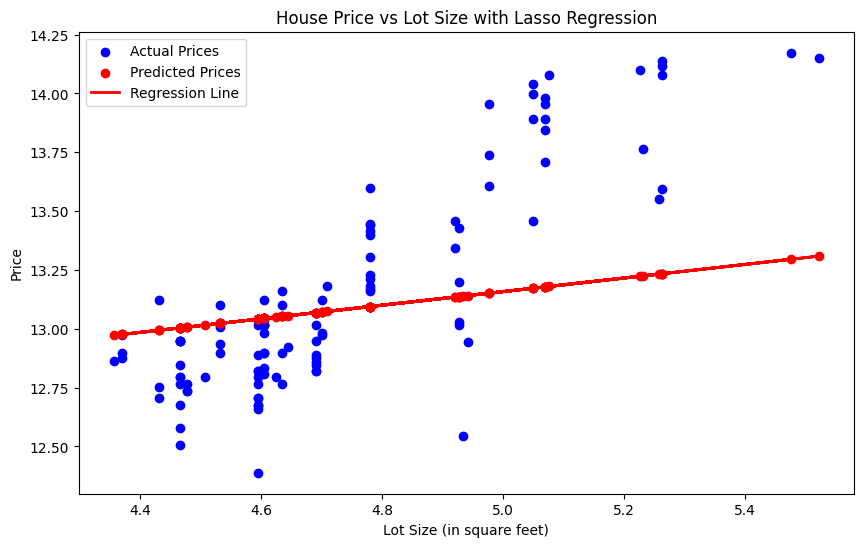

In [ ]:
# Filter the dataset for "Condominium/Apartment"
df_condo = cleaned_df[cleaned_df['CATEGORY'] == 'Condominium/Apartment'].copy()

# Log transformation
df_condo.loc[:, 'LOG_LOT_SIZE'] = np.log(df_condo['LOT_SIZE'])
df_condo.loc[:, 'LOG_PRICE'] = np.log(df_condo['PRICE'])

# Features (X) and target (Y)
X = df_condo[['LOG_LOT_SIZE']].values
Y = df_condo['LOG_PRICE'].values

# Split the data into training and testing sets
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.5, random_state=42)

# Create and train the lasso regression model
lasso = Lasso(alpha=0.1)  # Adjust alpha as needed
lasso.fit(X_train, Y_train)

# Make predictions on the test set
Y_pred = lasso.predict(X_test)

# Evaluate the model
mse = mean_squared_error(Y_test, Y_pred)
r2 = r2_score(Y_test, Y_pred)

print(f'Mean Squared Error: {mse}')
print(f'R-squared: {r2}')

# Plotting actual vs predicted prices
plt.figure(figsize=(10, 6))
plt.scatter(X_test, Y_test, color='blue', label='Actual Prices')
plt.scatter(X_test, Y_pred, color='red', label='Predicted Prices')
plt.plot(X_test, Y_pred, color='red', linewidth=2, label='Regression Line')
plt.xlabel('Lot Size (in square feet)')
plt.ylabel('Price')
plt.title('House Price vs Lot Size with Lasso Regression')
plt.legend()
plt.show()


In [ ]:
coefficient = lasso.coef_[0]
intercept = lasso.intercept_

print(f'Equation of the model: log(Price) = {coefficient:.2f} * log(Lot Size) + {intercept:.2f}')


Equation of the model: log(Price) = 0.29 * log(Lot Size) + 11.71


This is an example of how we can predict a price based on lot size:

In [ ]:
def predict_price(lot_size):
    log_lot_size = np.log(lot_size)
    log_price = coefficient * log_lot_size + intercept
    price = np.exp(log_price)
    return price

# Predict the price for a lot size of 99 square feet
lot_size = 99
predicted_price = predict_price(lot_size)
print(f"Predicted Price for a lot size of {lot_size} square feet: ${predicted_price:.2f}")

Predicted Price for a lot size of 99 square feet: $460999.55


As you can see our R-squared is significantly reduced (only R-squared: 0.2366 !!), so we need to finetune our Alpha

Best Alpha: 0.005428675439323859
Mean Squared Error: 0.05753104441693065
R-squared: 0.7080859149649035


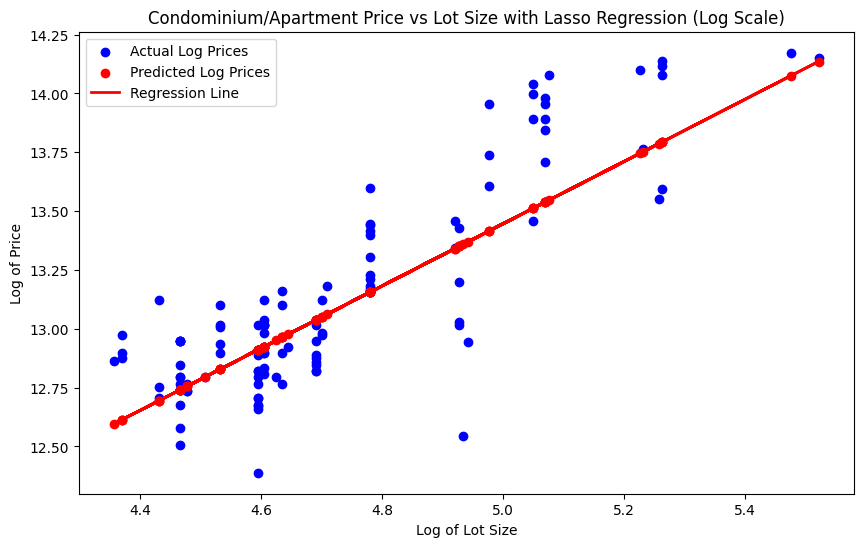

In [ ]:
from sklearn.model_selection import GridSearchCV

# Use GridSearchCV to find the best alpha
param_grid = {'alpha': np.logspace(-4, 1, 50)}
lasso = Lasso()
grid_search = GridSearchCV(lasso, param_grid, cv=5, scoring='r2')
grid_search.fit(X_train, Y_train)

# Best model
best_lasso = grid_search.best_estimator_

# Make predictions on the test set
Y_pred = best_lasso.predict(X_test)

# Evaluate the model
mse = mean_squared_error(Y_test, Y_pred)
r2 = r2_score(Y_test, Y_pred)

print(f'Best Alpha: {grid_search.best_params_["alpha"]}')
print(f'Mean Squared Error: {mse}')
print(f'R-squared: {r2}')


# Plotting actual vs predicted prices in log scale
plt.figure(figsize=(10, 6))
plt.scatter(X_test, Y_test, color='blue', label='Actual Log Prices')
plt.scatter(X_test, Y_pred, color='red', label='Predicted Log Prices')
plt.plot(X_test, Y_pred, color='red', linewidth=2, label='Regression Line')
plt.xlabel('Log of Lot Size')
plt.ylabel('Log of Price')
plt.title('Condominium/Apartment Price vs Lot Size with Lasso Regression (Log Scale)')
plt.legend()
plt.show()

Now, our R-squared is closer to 1 (0.708) after finetuning the alpha to find the best fit using gridSearch

In [ ]:
# Get the coefficient and intercept
coefficient = best_lasso.coef_[0]
intercept = best_lasso.intercept_

print(f'Coefficient: {coefficient}')
print(f'Intercept: {intercept}')

# The equation of the model in the log-transformed space
print(f'Equation of the model: log(Price) = {coefficient} * log(Lot Size) + {intercept}')


Coefficient: 1.3218488210976116
Intercept: 6.837298419506509
Equation of the model: log(Price) = 1.3218488210976116 * log(Lot Size) + 6.837298419506509


If we want to get the predicted price, we will need to use exponential which is the inverse of the log function.

In [64]:
def predict_price(lot_size):
    log_lot_size = np.log(lot_size)
    log_price = coefficient * log_lot_size + intercept
    price = np.exp(log_price)
    return price

# Predict the price for a lot size of 99 square feet
lot_size = 99
predicted_price = predict_price(lot_size)
print(f"Predicted Price for a lot size of {lot_size} square feet: RM{predicted_price:.2f}")

Predicted Price for a lot size of 99 square feet: RM404882.50
